# Public Goods Simulation Visualizer
This notebook reads simulation summary data and snapshot JSON to visualize cooperation dynamics.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import re

import tikzplotlib
import os

os.makedirs("figures", exist_ok=True)

In [14]:
# Parse L from filename
def parse_L(filename):
    match = re.search(r'_L(\d+)', filename)
    return int(match.group(1)) if match else None

# Parse model type from filename
def parse_model(filename):
    if "_A" in filename:
        return "A"
    elif "_B" in filename:
        return "B"
    else:
        return "Unknown"

# Choose which model to plot
model_to_plot = "B"  # Change to "B" if needed

# Load all matching files
files = sorted(glob.glob("data/*_summary.csv"))
df_all = pd.concat([
    pd.read_csv(f).assign(
        r0=float(f.split("r")[1].split("v")[0]) / 10,
        sigma=float(f.split("v")[1].split("_")[0]) / 100,
        L=parse_L(f),
        model=parse_model(f),
        alpha=round(float(f.split("v")[1].split("_")[0]) / 100 / (float(f.split("r")[1].split("v")[0]) / 10), 4)
    )
    for f in files
    if parse_model(f) == model_to_plot
])

# Final state only
df_final = df_all.groupby(['r0', 'sigma', 'alpha']).tail(1)
df_final

,time,C,mean_payoff,var_payoff,r0,sigma,L,model,alpha
2,1000,0.0000,0.00000,0.00000,2.0,0.20,100,B,0.1
2,1000,0.0000,0.00000,0.00000,2.0,0.40,100,B,0.2
2,1000,0.0000,0.00000,0.00000,2.0,0.60,100,B,0.3
2,1000,0.0000,0.00000,0.00000,2.0,0.80,100,B,0.4
2,1000,0.0000,0.00000,0.00000,2.0,1.00,100,B,0.5
2,1000,0.0000,0.00000,0.00000,2.5,0.25,100,B,0.1
2,1000,0.0000,0.00000,0.00000,2.5,0.50,100,B,0.2
2,1000,0.0000,0.00000,0.00000,2.5,0.75,100,B,0.3
3,1000,0.0000,0.00000,0.00000,2.5,1.00,100,B,0.4
3,1000,0.0000,0.00000,0.00000,2.5,1.25,100,B,0.5


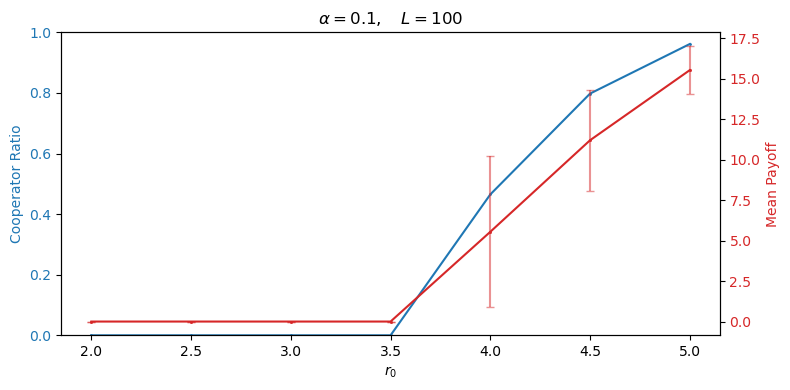

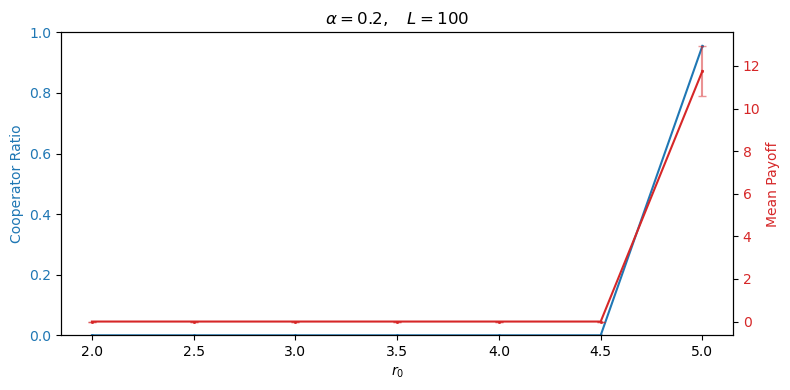

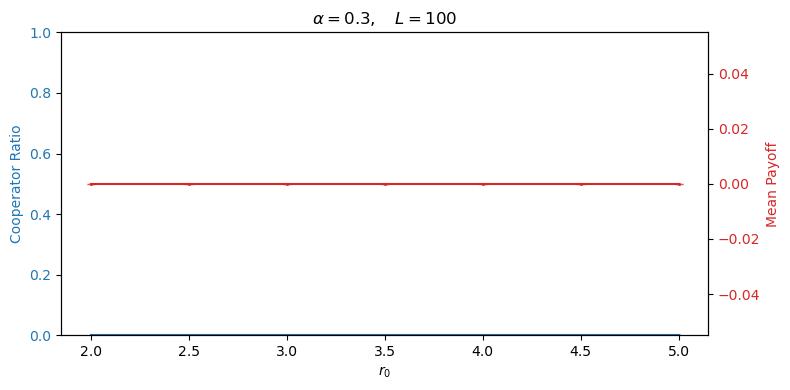

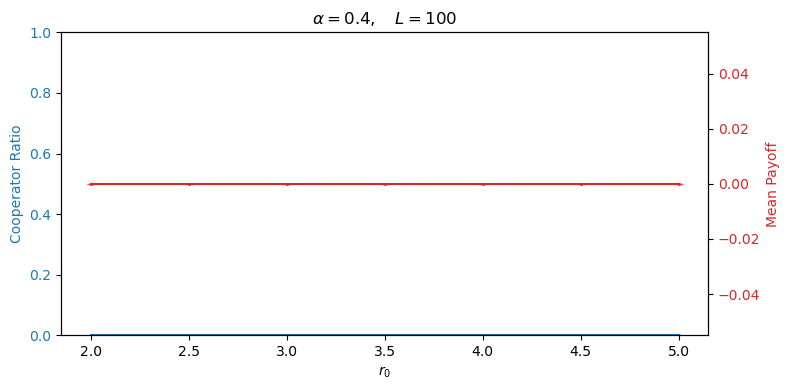

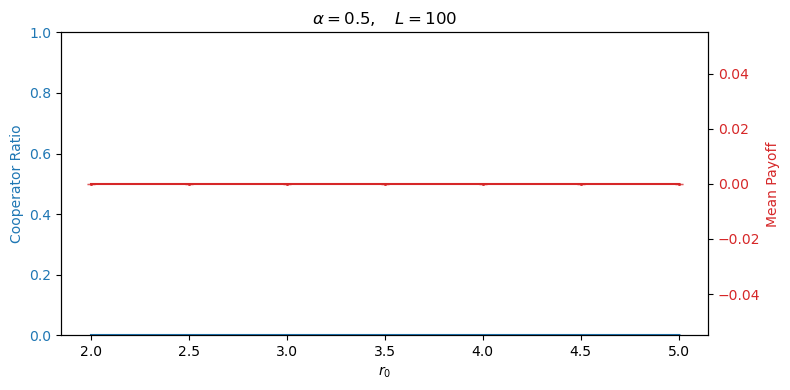

In [15]:
# Plot for each α
for alpha in sorted(df_final['alpha'].unique()):
    subset = df_final[df_final['alpha'] == alpha].sort_values('r0')

    x = subset['r0'].to_numpy()
    y_c = subset['C'].to_numpy()
    y_mean = subset['mean_payoff'].to_numpy()
    y_var = subset['var_payoff'].to_numpy()
    L_vals = subset['L'].to_numpy()
    N_vals = L_vals ** 2
    y_se = np.sqrt(y_var)  # Standard Error

    fig, ax1 = plt.subplots(figsize=(8, 4))

    # Left axis: cooperator ratio
    ax1.plot(x, y_c, marker='o', color='tab:blue', label='Cooperator ratio (C)', markersize=1)
    ax1.set_xlabel('$r_0$')
    ax1.set_ylabel('Cooperator Ratio', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, 1)

    # Right axis: mean payoff with SE bars
    ax2 = ax1.twinx()
    ax2.plot(x, y_mean, marker='s', color='tab:red', label='Mean payoff', markersize=1)
    ax2.errorbar(x, y_mean, yerr=y_se, fmt='none', ecolor='tab:red', alpha=0.5, capsize=3)
    ax2.set_ylabel('Mean Payoff', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    L_val = int(subset['L'].iloc[0])
    
    plt.title(rf'$\alpha = {alpha:.1f},\quad L = {L_val}$')
    fig.tight_layout()
    tikzplotlib.save(f"figures/alpha_{alpha:.1f}_{model_to_plot}.tex")
